In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
region_numbers = {"Mid-Atlantic Bight": 0, 
                  "Southern New England": 1, 
                  "Georges Bank": 2, 
                  "Gulf of Maine": 3, 
                  "Bay of Fundy": 4, 
                  "Scotian Shelf": 5, 
                  "Off-Shelf": 6, 
                  np.nan: 7}

In [3]:
def get_data(species):
    data_base = pd.read_csv("../data/model_sims/baseline/{}/settled_data.csv".format(species))
    data_base = data_base.drop(columns=["Unnamed: 0"])

    data_warm = pd.read_csv("../data/model_sims/warm/{}/settled_data.csv".format(species))
    data_warm = data_warm.drop(columns=["Unnamed: 0"])
    
    return data_base, data_warm

In [4]:
def generate_connectivity_matrix(data):

    init_region_numbers = data[data['settled_particles'] == 1.0]['init_region'].map(region_numbers)
    final_region_numbers = data[data['settled_particles'] == 1.0]['final_region'].map(region_numbers)

    matrix = np.zeros(shape=(8, 8))
    regions = zip(init_region_numbers, final_region_numbers)
    for i, f, in regions:
        matrix[int(f)][int(i)] += 1
    matrix = matrix[:-2, :-2]    
    matrix_std = matrix/sum(matrix)
    
    return matrix, matrix_std

In [5]:
def compute_annual_cm(d, y):
    data = d[d.years == y]

    mat, mat_std = generate_connectivity_matrix(data)
    return mat, mat_std

def average_cms_annual(data, years):
    mats = np.zeros(shape=(5, 6, 6))
    mats_std = np.zeros(shape=(5, 6, 6))
    for i, y in enumerate(years):
        mat, mat_std = compute_annual_cm(data, y)
        mats[i, :, :] = mat
        mats_std[i, :, :] = mat_std

    return mats_std.mean(axis=0), mats_std.std(axis=0), mats, mats_std

def ttest(cm_base, cm_warm):
    ttest = stats.ttest_ind(cm_warm, cm_base)
    pvals = ttest.pvalue
    sig_idx = np.where(pvals < 0.05)[0]
    sig_dis = sig_idx*10
    return sig_dis, sig_idx, pvals

In [6]:
def plot_connectivity_matrix(basecm, warmcm, diffcm, title):
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))

    ax1, ax2, ax3 = axes.ravel()

    im1 = ax1.imshow(basecm, cmap='jet', interpolation='nearest', vmin=0, vmax=1)
    im2 = ax2.imshow(warmcm, cmap='jet', interpolation='nearest', vmin=0, vmax=1)
    im3 = ax3.imshow(diffcm, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)

    region_names = ['Mid-Atlantic Bight','Southern New England','Georges Bank','Gulf of Maine','Bay of Fundy','Scotian Shelf']


    for ax in axes:
        ax.set_xticks(np.arange(len(diff_cm)))
        ax.set_xticklabels(region_names, snap=True, rotation=45, ha="right")
        ax.set_yticklabels("")
    ax1.set_yticks(np.arange(len(diff_cm)))
    ax1.set_yticklabels(region_names, snap=True)

    ax1.set_ylabel("Larvae Sink Region")
    ax2.set_xlabel("Larvae Source Region")

    cbaxes1 = fig.add_axes([0.35, 0.13, 0.02, 0.75])
    cbaxes2 = fig.add_axes([0.625, 0.13, 0.02, 0.75])
    cbaxes3 = fig.add_axes([0.90, 0.13, 0.02, 0.75])

    cb = plt.colorbar(im1, ax=ax1, cax = cbaxes1)
    cb = plt.colorbar(im2, ax=ax1, cax = cbaxes2)
    cb = plt.colorbar(im3, ax=ax1, cax = cbaxes3)

    ax1.set_title("Baseline Period Connectivity Matrix")
    ax2.set_title("Warm Period Connectivity Matrix")
    ax3.set_title("Period Difference Connectivity Matrix")

    fig.suptitle(title)
    
    return fig, axes

# Atlantic Cod

In [7]:
data_base, data_warm = get_data("atlantic-cod")

In [8]:
base_cm_mean, base_cm_std, _, base_cm_stand = average_cms_annual(data_base, range(1984, 1989))
warm_cm_mean, warm_cm_std, _, warm_cm_stand  = average_cms_annual(data_warm, range(2012, 2017))
diff_cm = (warm_cm_mean - base_cm_mean)/sum(base_cm_mean)

In [10]:
np.round(base_cm_mean, 4)

array([[9.353e-01, 7.050e-02, 2.100e-03, 1.000e-04, 0.000e+00, 0.000e+00],
       [6.470e-02, 9.149e-01, 1.741e-01, 1.644e-01, 0.000e+00, 4.300e-03],
       [1.000e-04, 1.060e-02, 7.112e-01, 4.790e-02, 0.000e+00, 3.410e-02],
       [0.000e+00, 3.800e-03, 1.036e-01, 7.309e-01, 2.170e-01, 2.082e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, 4.700e-02, 7.829e-01, 3.490e-02],
       [0.000e+00, 1.000e-04, 9.000e-03, 9.800e-03, 0.000e+00, 7.185e-01]])

In [67]:
ttest = stats.ttest_ind(warm_cm_stand, base_cm_stand)
pvals = ttest.pvalue
pvals

array([[0.50751234, 0.24206917, 0.6060711 , 0.35427882, 0.34659351,
        0.34659351],
       [0.63528439, 0.65620445, 0.58720643, 0.26727825, 0.34659351,
        0.37333264],
       [0.34759873, 0.75529418, 0.64390287, 0.41454519, 0.34686834,
        0.75125207],
       [0.34659351, 0.40954344, 0.8287574 , 0.47826676, 0.11922302,
        0.27127375],
       [0.34659351, 0.34659351, 0.34704794, 0.99198836, 0.35095009,
        0.51171284],
       [0.34659351, 0.34972616, 0.9886176 , 0.27577695, 0.34564458,
        0.68829229]])

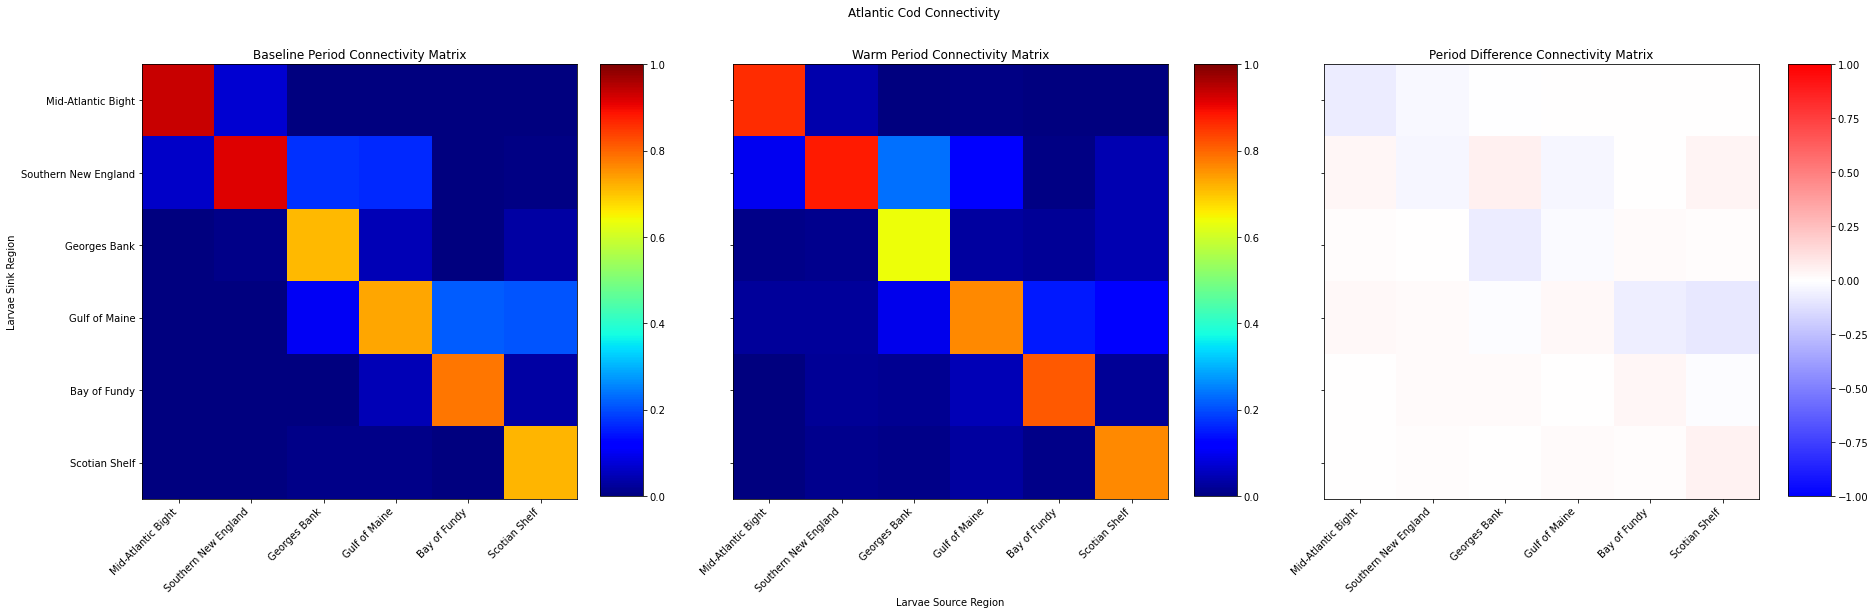

In [52]:
fig, axes = plot_connectivity_matrix(base_cm_mean, warm_cm_mean, diff_cm, title="Atlantic Cod Connectivity")

**Figure 1 - Atlantic Cod Connectivity Matrix -** Atlantic Cod exhibited no significant regional changes in connectivity between the two time periods. There was a minimal decrease in self-recruitment in the Mid Atlantic Bight, Southern New England, and Georges Bank regions in the warm time period. A similar minimal increase in self-recruitment in the three, more northerly, regions was also identified. 

# Haddock

In [68]:
data_base, data_warm = get_data("haddock")

In [70]:
base_cm_mean, base_cm_std, _, base_cm_stand = average_cms_annual(data_base, range(1984, 1989))
warm_cm_mean, warm_cm_std, _, warm_cm_stand  = average_cms_annual(data_warm, range(2012, 2017))
diff_cm = (warm_cm_mean - base_cm_mean)/sum(base_cm_mean)

In [71]:
ttest = stats.ttest_ind(warm_cm_stand, base_cm_stand)
pvals = ttest.pvalue
pvals

array([[0.73662681, 0.80547142, 0.74949904, 0.43750184,        nan,
        0.70475339],
       [0.70772319, 0.32913715, 0.68937014, 0.70647557, 0.26000459,
        0.43165564],
       [0.34568662, 0.55609114, 0.53427544, 0.09077217, 0.47327807,
        0.96916965],
       [0.3013218 , 0.46518325, 0.79744623, 0.12157754, 0.74275076,
        0.07048384],
       [       nan,        nan, 0.39612444, 0.00191389, 0.79339721,
        0.25939525],
       [0.56831764, 0.85571968, 0.28080158, 0.06706769, 0.05902866,
        0.19765626]])

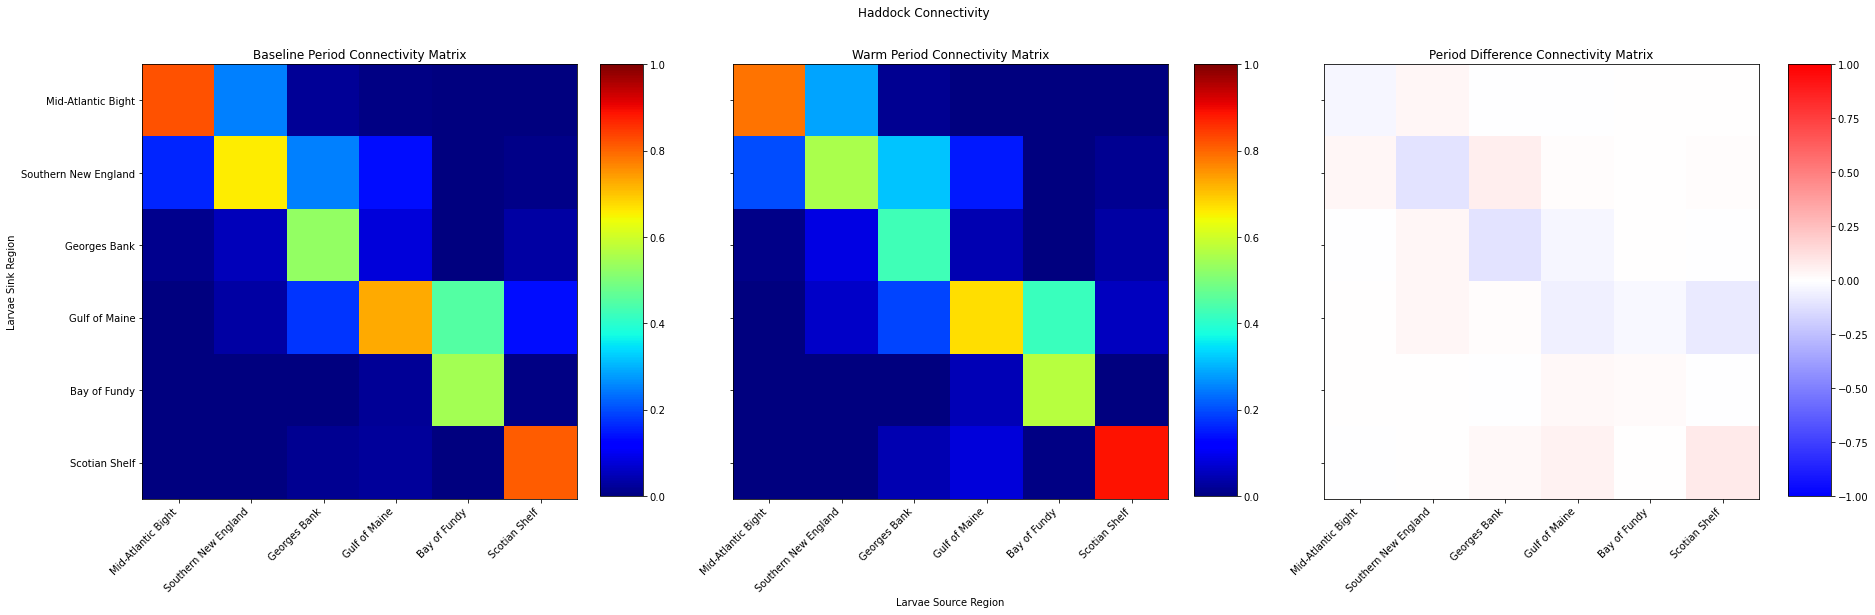

In [55]:
fig, axes = plot_connectivity_matrix(base_cm_mean, warm_cm_mean, diff_cm, title="Haddock Connectivity")

**Figure 2 - Haddock Connectivity Matrix-** Haddock exhibited no significant changes in regional connectivity between the two time periods. The MAB, SNE, GBK, and GOM regions saw small reductions in self-recruitment. Additionally, the Scotian Shelf saw a slight general increase in connectivity with the rest of the NES, while the Gulf of Maine saw a similar reduction in connectivity.

# Yellowtail Flounder

In [78]:
data_base, data_warm = get_data("yellowtail-flounder")

In [79]:
base_cm_mean, base_cm_std, _, base_cm_stand = average_cms_annual(data_base, range(1984, 1989))
warm_cm_mean, warm_cm_std, _, warm_cm_stand  = average_cms_annual(data_warm, range(2012, 2017))
diff_cm = (warm_cm_mean - base_cm_mean)/sum(base_cm_mean)

In [80]:
ttest = stats.ttest_ind(warm_cm_stand, base_cm_stand)
pvals = ttest.pvalue
pvals

array([[0.95738005, 0.67714232, 0.53590735, 0.40996788, 0.40742253,
        0.32933507],
       [0.98086849, 0.63289278, 0.0688041 , 0.02084209, 0.4411791 ,
        0.89032449],
       [0.48677854, 0.71384118, 0.34610085, 0.00648229, 0.36661127,
        0.22922179],
       [0.55348291, 0.64399958, 0.07231756, 0.38914822, 0.38960142,
        0.20025587],
       [0.46085359, 0.43800881, 0.61069854, 0.68618209, 0.60708026,
        0.67980802],
       [0.34514115, 0.39811241, 0.2065827 , 0.40803017, 0.17292405,
        0.32876207]])

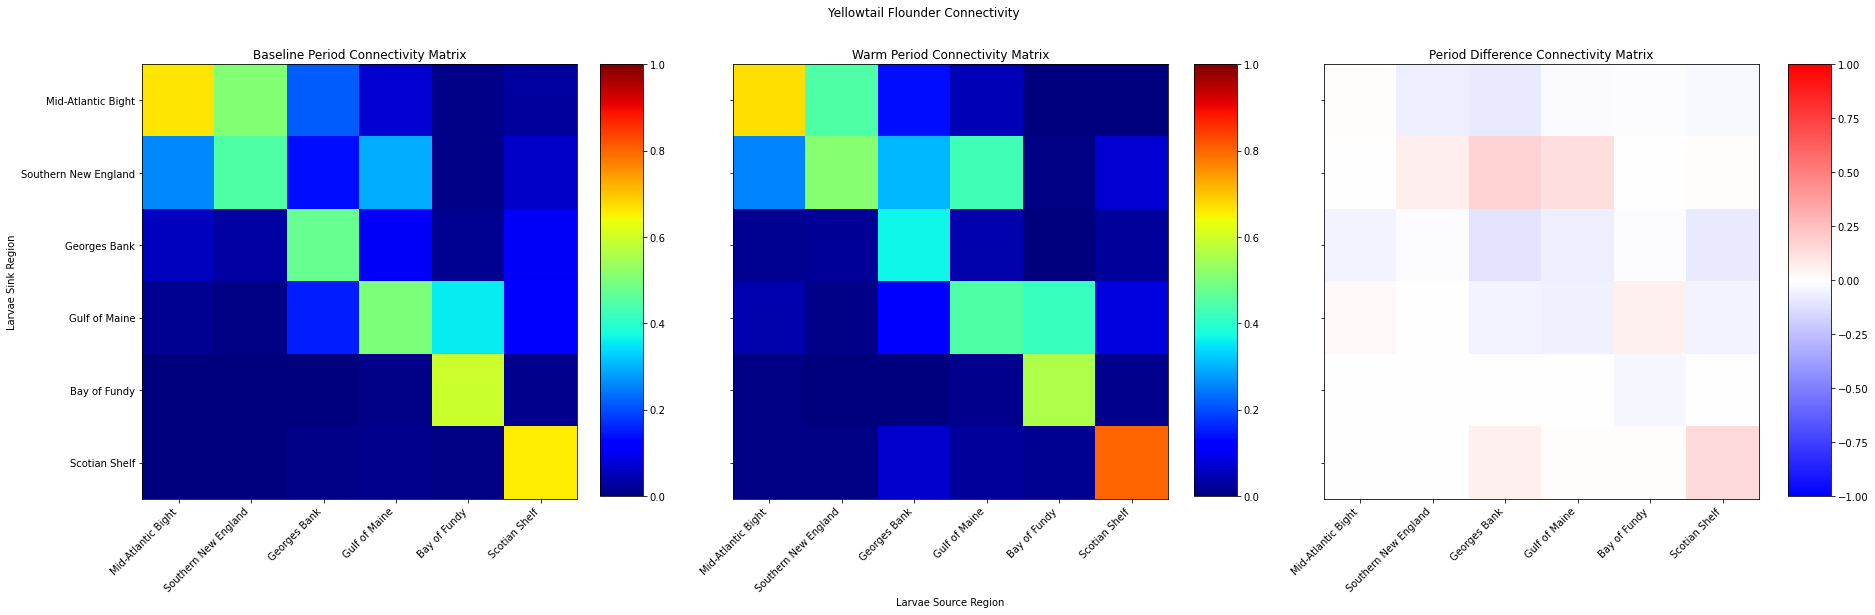

In [85]:
fig, axes = plot_connectivity_matrix(base_cm_mean, warm_cm_mean, diff_cm, title="Yellowtail Flounder Connectivity")

**Figure 3 - Yellowtail Flounder Connectivity Matrix -** Yellowtail Flounder saw a significant decrease in connectivity between the Gulf of Maine and Georges Bank and a significant increase in connectivity between the Gulf of Maine and Southern New England. Connectivity between George's Bank and the Gulf of Maine decreased overall

# Atlantic Mackerel

In [75]:
data_base, data_warm = get_data("atlantic-mackerel")

In [76]:
base_cm_mean, base_cm_std, _, base_cm_stand = average_cms_annual(data_base, range(1984, 1989))
warm_cm_mean, warm_cm_std, _, warm_cm_stand  = average_cms_annual(data_warm, range(2012, 2017))
diff_cm = (warm_cm_mean - base_cm_mean)/sum(base_cm_mean)

In [77]:
ttest = stats.ttest_ind(warm_cm_stand, base_cm_stand)
pvals = ttest.pvalue
pvals

array([[3.93020557e-01, 9.77097376e-04, 6.21499714e-02, 1.10399444e-01,
        1.58798986e-01, 9.83947505e-01],
       [8.67237702e-01, 5.75775246e-01, 3.58159571e-01, 1.16910753e-01,
        5.96589810e-02, 8.45967755e-01],
       [9.48526020e-02, 1.04708014e-01, 8.64778483e-01, 9.13143035e-01,
        1.80428086e-01, 3.86037831e-01],
       [2.41556041e-01, 4.33073515e-02, 5.49532585e-01, 1.13909236e-01,
        8.88340693e-02, 3.48800177e-01],
       [1.43072750e-01, 2.96998722e-01, 3.06326755e-01, 8.55328851e-01,
        6.59013184e-02, 3.21714736e-01],
       [3.25074469e-01, 1.49204678e-02, 1.72319724e-01, 7.60609424e-01,
        1.89262938e-01, 4.04925083e-01]])

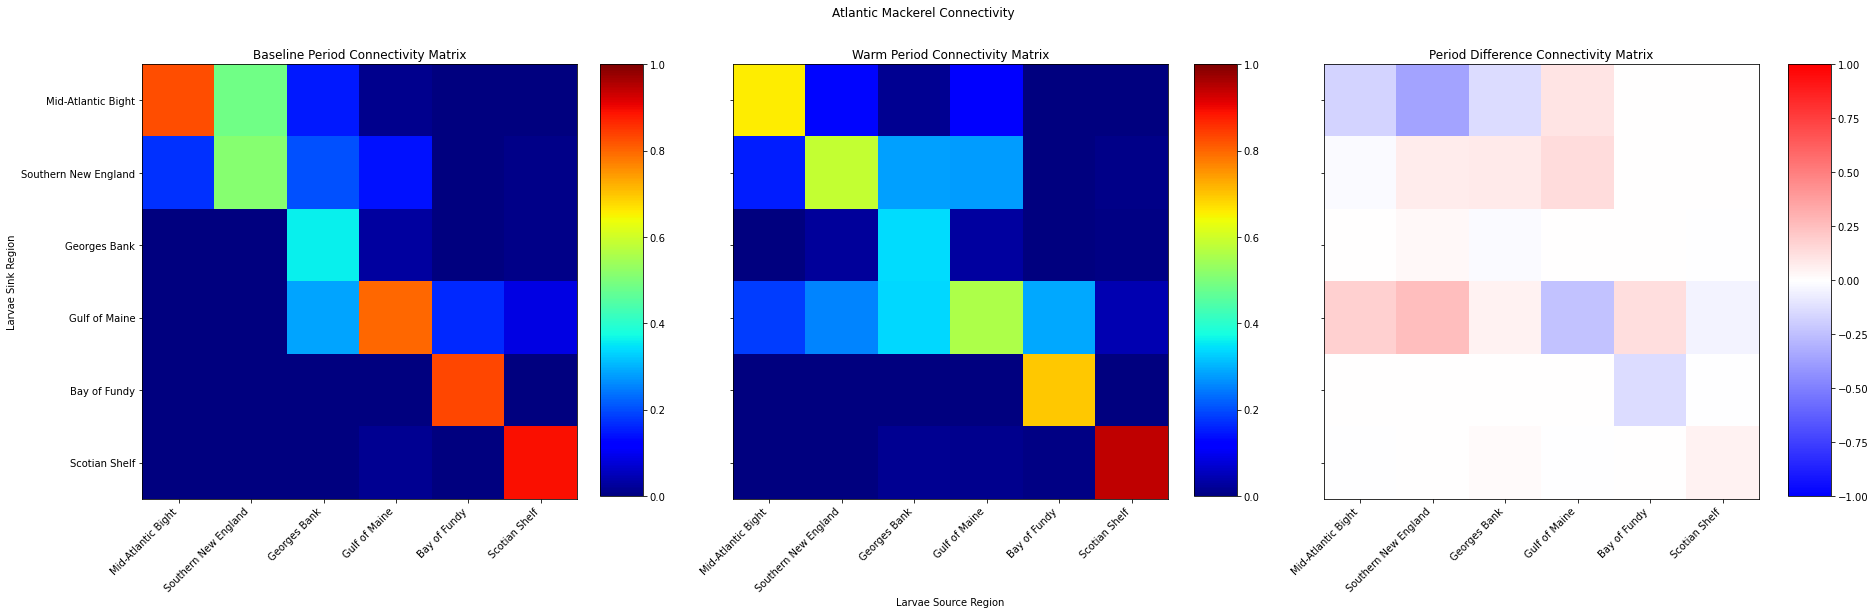

In [61]:
fig, axes = plot_connectivity_matrix(base_cm_mean, warm_cm_mean, diff_cm, title="Atlantic Mackerel Connectivity")

# American Butterfish

In [11]:
data_base, data_warm = get_data("american-butterfish")

In [12]:
base_cm_mean, base_cm_std, _, base_cm_stand = average_cms_annual(data_base, range(1984, 1989))
warm_cm_mean, warm_cm_std, _, warm_cm_stand  = average_cms_annual(data_warm, range(2012, 2017))
diff_cm = (warm_cm_mean - base_cm_mean)/sum(base_cm_mean)

In [15]:
np.round(base_cm_mean, 2)

array([[0.89, 0.54, 0.31, 0.28, 0.23, 0.14],
       [0.1 , 0.44, 0.24, 0.22, 0.02, 0.05],
       [0.01, 0.  , 0.37, 0.03, 0.  , 0.01],
       [0.01, 0.01, 0.07, 0.46, 0.05, 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.7 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.77]])

In [77]:
ttest = stats.ttest_ind(warm_cm_stand, base_cm_stand)
pvals = ttest.pvalue
pvals

array([[3.93020557e-01, 9.77097376e-04, 6.21499714e-02, 1.10399444e-01,
        1.58798986e-01, 9.83947505e-01],
       [8.67237702e-01, 5.75775246e-01, 3.58159571e-01, 1.16910753e-01,
        5.96589810e-02, 8.45967755e-01],
       [9.48526020e-02, 1.04708014e-01, 8.64778483e-01, 9.13143035e-01,
        1.80428086e-01, 3.86037831e-01],
       [2.41556041e-01, 4.33073515e-02, 5.49532585e-01, 1.13909236e-01,
        8.88340693e-02, 3.48800177e-01],
       [1.43072750e-01, 2.96998722e-01, 3.06326755e-01, 8.55328851e-01,
        6.59013184e-02, 3.21714736e-01],
       [3.25074469e-01, 1.49204678e-02, 1.72319724e-01, 7.60609424e-01,
        1.89262938e-01, 4.04925083e-01]])

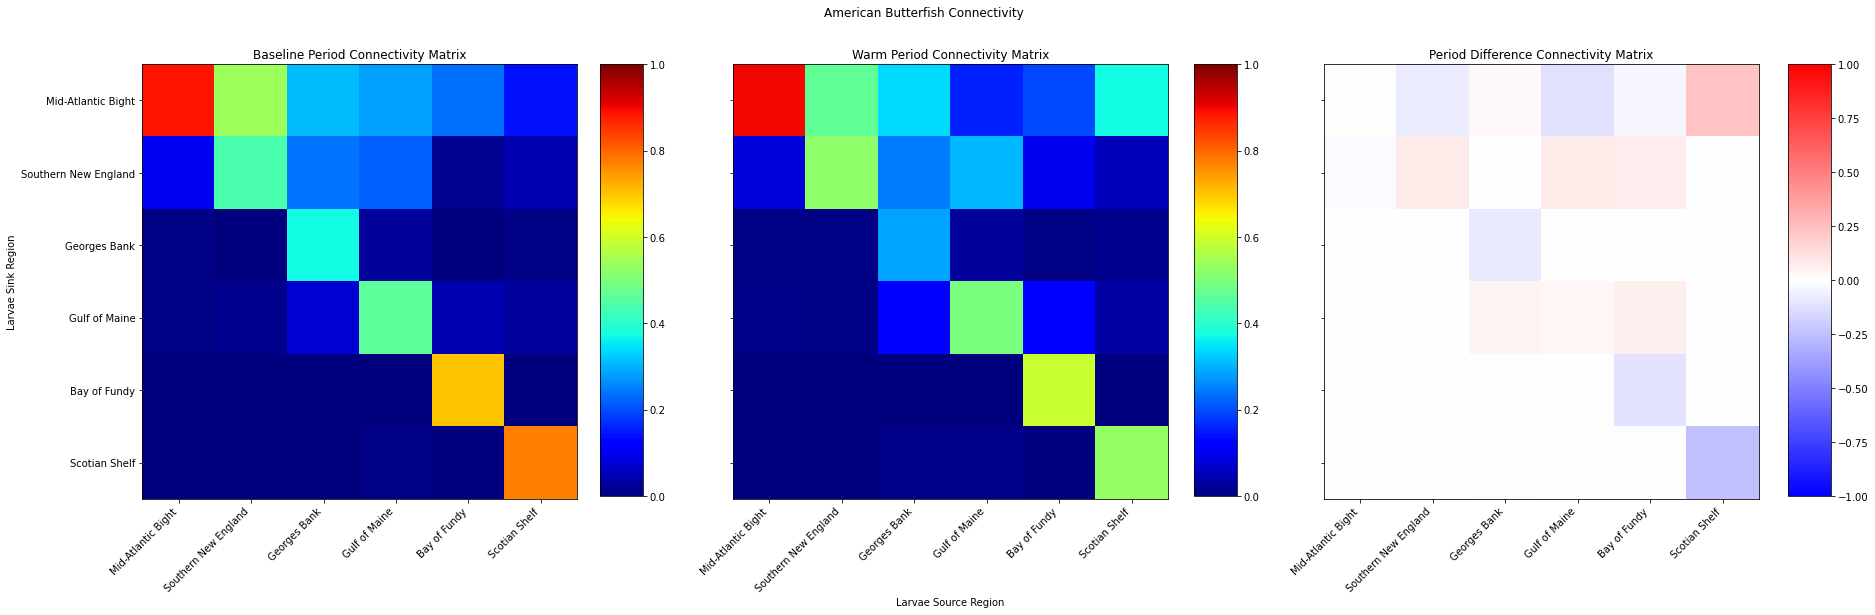

In [14]:
fig, axes = plot_connectivity_matrix(base_cm_mean, warm_cm_mean, diff_cm, title="American Butterfish Connectivity")